# Importing data and libraries

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_edf(filename):
    data = mne.io.read_raw_edf(filename)
    raw_data = data.get_data()
    # you can get the metadata included in the file and a list of all channels:
    # info = data.info
    channels = data.ch_names
  
    return raw_data, channels

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
path='./dataset/'

In [4]:
# Read annotations

annotation_path_A = path + '\\annotations_2017_A.csv'
annotation_path_B = path + '\\annotations_2017_B.csv'
annotation_path_C = path + '\\annotations_2017_C.csv'

annotation_data_A = pd.read_csv(annotation_path_A)
annotation_data_B = pd.read_csv(annotation_path_B)
annotation_data_C = pd.read_csv(annotation_path_C)

annotation_data_dict={'A':annotation_data_A,'B':annotation_data_B,'C':annotation_data_C}

# Extracting data for pre-seizure vs non-pre seizure chunks

In [5]:
def get_seizure_seconds_for_patient_i_doctor_j(i,j):
    "i can take value in range(0,79) while j can take value among A, B or C"
    "For patient i and doctor j this function gives us the all the non seizure seconds"
    annotation_data =annotation_data_dict[j]
    annotation_data_patient_i=np.array(annotation_data.iloc[:,i])
    seizure_chunks=[]
    single_chunk=[]
    flag=False
    for i in range(len(annotation_data_patient_i)-1):
        if flag==True:
            single_chunk=[]
            flag=False
        if annotation_data_patient_i[i]==annotation_data_patient_i[i+1] and annotation_data_patient_i[i]==1:
            single_chunk.append(i)
        else:
            flag=True
            single_chunk.append(i)
            if len(single_chunk)>1:
                seizure_chunks.append(np.array(single_chunk))
    return np.array(seizure_chunks,dtype=object)

In [6]:
def get_non_seizure_seconds_for_patient_i_doctor_j(i,j):
    "i can take value in range(0,79) while j can take value among A, B or C"
    "For patient i and doctor j this function gives us the all the non seizure seconds"
    annotation_data =annotation_data_dict[j]
    annotation_data_patient_i=np.array(annotation_data.iloc[:,i])
    seizure_chunks=[]
    single_chunk=[]
    flag=False
    for i in range(len(annotation_data_patient_i)-1):
        if flag==True:
            single_chunk=[]
            flag=False
        if annotation_data_patient_i[i]==annotation_data_patient_i[i+1] and annotation_data_patient_i[i]==0:
            single_chunk.append(i)
        else:
            flag=True
            single_chunk.append(i)
            if len(single_chunk)>1:
                seizure_chunks.append(np.array(single_chunk))
    return np.array(seizure_chunks,dtype=object)

In [7]:
def get_non_seizure_seconds_for_patient_i_all_doctors(i):
    "For patient i this function gives us the all the non seizure seconds that all doctors agree upon"
    A=get_non_seizure_seconds_for_patient_i_doctor_j(i,'A')
    B=get_non_seizure_seconds_for_patient_i_doctor_j(i,'B')
    C=get_non_seizure_seconds_for_patient_i_doctor_j(i,'C')
    A_B_C_agrees=np.array(list((set(np.concatenate(A)).intersection(np.concatenate(B))).intersection(np.concatenate(C))))
    seizure_chunks=[]
    single_chunk=[]
    flag=False
    for i in range(len(A_B_C_agrees)-1):
        if flag==True:
            single_chunk=[]
            flag=False
        if A_B_C_agrees[i]+1==A_B_C_agrees[i+1]:
            single_chunk.append(A_B_C_agrees[i])
        else:
            flag=True
            single_chunk.append(A_B_C_agrees[i])
            if len(single_chunk)>1:
                seizure_chunks.append(np.array(single_chunk))
    return np.array(seizure_chunks,dtype=object)

We vizualize the frequency distribution of the non seizure chunks

In [8]:
non_seizure_chunk_lengths=[]
for patient in range(79):
    non_seizure_chunks=get_non_seizure_seconds_for_patient_i_all_doctors(patient)
    for chunk in non_seizure_chunks: 
        non_seizure_chunk_lengths.append(len(chunk))

In [9]:
len(np.array(non_seizure_chunk_lengths)[np.where(np.array(non_seizure_chunk_lengths)>=60)[0]])

331

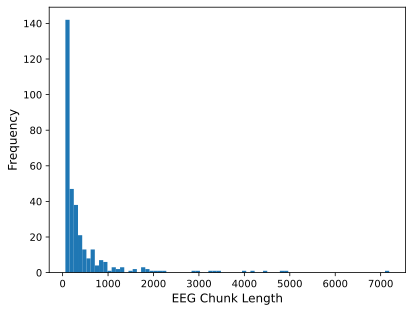

In [10]:
plt.hist(np.array(non_seizure_chunk_lengths)[np.where(np.array(non_seizure_chunk_lengths)>=60)[0]], bins='auto') 
plt.xlabel("EEG Chunk Length",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.show()

In [11]:
def get_pre_seizure_chunks(chunk_length=60,padding_before_seizure=60):
    "This function extracts chunks of pre seizure seconds for a given chunk length and padding length before seizure starts"
    pre_seizure_chunks_for_patients=[]
    patient_index=[]
    for patient in range(79):
        chunks=get_non_seizure_seconds_for_patient_i_all_doctors(patient)
        for chunk in chunks:
            if len(chunk)-padding_before_seizure>chunk_length:
                sample_pre_seizure_chunks_for_patient_i=chunk[-chunk_length:]
                pre_seizure_chunks_for_patients.append(np.array(sample_pre_seizure_chunks_for_patient_i))
                patient_index.append(patient)
    return np.array(pre_seizure_chunks_for_patients), np.array(patient_index)

In [12]:
pre_seizure_chunks, patient_index=get_pre_seizure_chunks()

In [13]:
def get_non_pre_seizure_chunks(chunk_length=60,padding_before_seizure=60):
    "This function extracts chunks of non pre seizure seconds for a given chunk length and padding length before seizure starts"
    non_pre_seizure_chunks_for_patients=[]
    patient_index=[]
    for patient in range(79):
        rough_non_pre_seiure_chunks_patient_i=np.array([chunk[:-(chunk_length+padding_before_seizure)] for chunk in get_non_seizure_seconds_for_patient_i_all_doctors(patient)],dtype='object')
        for big_chunk in rough_non_pre_seiure_chunks_patient_i:
            if len(big_chunk)>chunk_length:
                stating_point=0
                ending_point=chunk_length
                num_chunks=len(big_chunk)//chunk_length
                for i in range(num_chunks):
                    small_chunk=big_chunk[stating_point:ending_point]
                    stating_point+=chunk_length
                    ending_point+=chunk_length
                    non_pre_seizure_chunks_for_patients.append(small_chunk)
                    patient_index.append(patient)
    return np.array(non_pre_seizure_chunks_for_patients), np.array(patient_index)

In [14]:
non_pre_seizure_chunks, non_patient_index=get_non_pre_seizure_chunks()

# Mapping to EEG data:

In [15]:
# Mapping the pre - Seizure chunks into the EEG dataset: Chunk length=60, Padding before seizure=60

path = r'C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset'

eeg_data_pre_seizure = []

for seizure_chunk in range(len(pre_seizure_chunks)):
    patient_id = patient_index[seizure_chunk]
    filename = path + '\\eeg'+str(patient_id+1)+'.edf'
    sigbufs, signal_labels = read_edf(filename)
    n_channels = len(sigbufs)
    eeg_channels_data = []
    for i in range(n_channels):
        eeg_signal = sigbufs[i][256*pre_seizure_chunks[seizure_chunk][0]:256*pre_seizure_chunks[seizure_chunk][-1]]
        eeg_channels_data.append((eeg_signal))
    eeg_data_pre_seizure.append(np.array(eeg_channels_data))
    
print(len(eeg_data_pre_seizure))


Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure

In [ ]:
# Mapping the pre - Seizure chunks into the EEG dataset.

path = r'C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset'

eeg_data_non_pre_seizure = []

for seizure_chunk in range(len(non_pre_seizure_chunks)):
    patient_id = non_patient_index[seizure_chunk]
    filename = path + '\\eeg'+str(patient_id+1)+'.edf'
    sigbufs, signal_labels = read_edf(filename)
    n_channels = len(sigbufs)
    eeg_channels_data = []
    for i in range(n_channels):
        eeg_signal = sigbufs[i][256*non_pre_seizure_chunks[seizure_chunk][0]:256*non_pre_seizure_chunks[seizure_chunk][-1]]
        eeg_channels_data.append((eeg_signal))
    eeg_data_non_pre_seizure.append(np.array(eeg_channels_data))
    
print(len(eeg_data_non_pre_seizure))

Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\user\Desktop\Manuscript Projects@IISERTVM\EEG data\Neonatal EEG\dataset\eeg1.edf...
EDF file detected
Setting channel info structure

In [ ]:
eeg_data_pre_seizure=np.array(eeg_data_pre_seizure)
eeg_data_non_pre_seizure=np.array(eeg_data_non_pre_seizure)

In [ ]:
eeg_data_pre_seizure.shape

In [ ]:
eeg_data_non_pre_seizure.shape

In [ ]:
np.save('eeg_data_pre_seizure_chl60_pad_60.npy', eeg_data_pre_seizure)
np.save('eeg_data_non_pre_seizure.npy', eeg_data_non_pre_seizure)

# Vizualizing Seizure vs Non-Seizure chunks

In [ ]:
def vizualize_eeg_channels(signal,offset=0.0005):
    # Set the number of channels and the offset between each channel
    n_channels = len(signal)
    offset = 0.0005
    
    # Set the left and right margins for the window in which we want to plot the data at
    
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Plot each signal with an offset
    for i in range(n_channels):
      ax.plot(signal[i] + i * offset, label=signal_labels[i])
    
    # Set the y-axis labels to the signal labels
    ax.set_yticks(np.arange(n_channels) * offset)
    ax.set_yticklabels(signal_labels)
    
    # Set the x-axis label
    ax.set_xlabel("Time")
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()
